In [3]:
import numpy as np

embeddings = np.load("comparison/embeddings_test_lower0.npy") 
# for i in range(1, 5):  # 从 1 开始，避免覆盖初始化的 embeddings
#     embeddings = np.concatenate((embeddings, np.load(f'comparison/embeddings_lower{i}.npy')), axis=0)

labels = np.load("comparison/labels_lower0.npy")
# for i in range(1, 5):
#     labels = np.concatenate((labels, np.load(f'comparison/labels_lower{i}.npy')))


## Supervised model

In [4]:
import torch
import torch.nn as nn

# 重新定義 Classifier 類別
class Classifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  

torch.serialization.add_safe_globals([Classifier])


In [6]:
import torch
import pickle
model = torch.load("classsifer_model/classifier_model_lower_test.pth", weights_only=False)

model.eval()  
threshold = 0.4

def predict(model, new_embeddings):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 自動選擇 GPU 或 CPU
    model.to(device)  # 將模型移到對應設備
    new_embeddings = torch.tensor(new_embeddings, dtype=torch.float32).to(device)  # 轉換為 tensor 並移到設備

    with torch.no_grad():  # 禁用梯度計算，加速推理
        outputs = model(new_embeddings)  # 模型輸出 logits
        probabilities = torch.softmax(outputs, dim=1)  # 轉為機率分佈
        
        predictions = torch.argmax(outputs, dim=1)  # 取得預測類別
        max_probs, max_indices = torch.max(probabilities, dim=1)  # 取得最大機率及其對應的類別索引
        predictions = torch.where(max_probs >= threshold, max_indices, torch.tensor(-1, device=outputs.device))


    return predictions.cpu().numpy() 

# 4. **測試新資料**
predictions_supervised = predict(model, new_embeddings=embeddings)


In [7]:
import numpy as np


print("Predicted labels:", predictions_supervised)


Predicted labels: [1 0 3 ... 1 1 1]


In [8]:
np.count_nonzero(predictions_supervised == -1), len(predictions_supervised)

(1, 1041)

In [9]:
def get_acc(pred, y_test):
    return np.sum(y_test == pred) / len(y_test) 

acc = get_acc(predictions_supervised, labels)

from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(labels, predictions_supervised, average='weighted')  # 二分类
recall = recall_score(labels, predictions_supervised, average='weighted')
f1 = f1_score(labels, predictions_supervised, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"accuracy: {acc:.4f}")


Precision: 0.8336
Recall: 0.8069
F1-score: 0.8044
accuracy: 0.8069


In [18]:
import numpy as np

labels = np.array(labels)  # 轉換為 NumPy 陣列
mask = labels != -1  # 建立布林遮罩
filtered_labels = labels[mask]  # 取出不為 -1 的值
filtered_predicted_supervised = predictions_supervised[mask]

acc = get_acc(filtered_predicted_supervised, filtered_labels)
precision = precision_score(filtered_labels, filtered_predicted_supervised, average='macro')  # 二分类
recall = recall_score(filtered_labels, filtered_predicted_supervised, average='macro')
f1 = f1_score(filtered_labels, filtered_predicted_supervised, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"accuracy: {acc:.4f}")


Precision: 0.6627
Recall: 0.7426
F1-score: 0.6837
accuracy: 83.0040


/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
import numpy as np

labels = np.array(labels)  # 轉換為 NumPy 陣列
mask = labels != -1  # 建立布林遮罩
filtered_labels = labels[mask]  # 取出不為 -1 的值
filtered_predicted_supervised = predictions_supervised[mask]

get_acc(filtered_predicted_supervised, filtered_labels)


83.00395256916995

## Average model

In [20]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


averages = np.load('average_model/average_lower_test.npy')
threshold = 0.95
similarity_matrix = cosine_similarity(embeddings, averages)
max_sim_indices = np.argmax(similarity_matrix, axis=1)
max_sim_values = np.max(similarity_matrix, axis=1)
predicted_averages = np.where(max_sim_values >= threshold, max_sim_indices, -1)
print("Predicted labels:", predicted_averages)

Predicted labels: [1 0 3 ... 1 1 1]


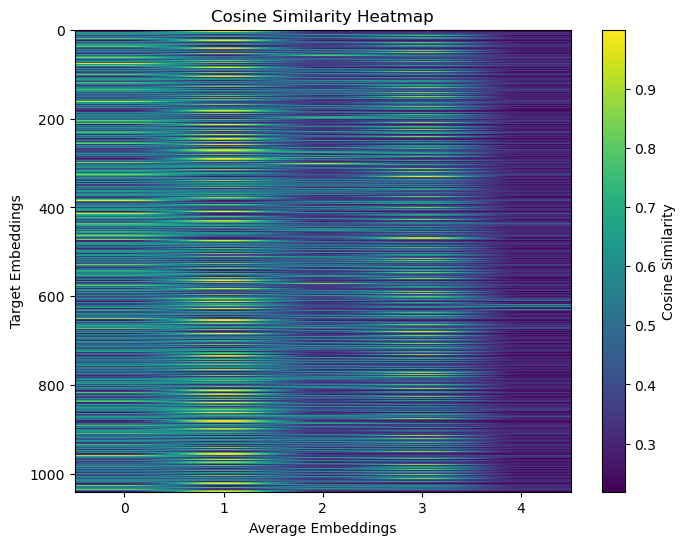

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Average Embeddings')
plt.ylabel('Target Embeddings')
plt.title('Cosine Similarity Heatmap')
plt.show()

In [22]:
np.count_nonzero(predicted_averages == -1), len(predicted_averages)

(64, 1041)

In [23]:
def get_acc(pred, y_test):
    return np.sum(y_test == pred) / len(y_test) * 100

acc = get_acc(predicted_averages, labels)

from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(labels, predicted_averages, average='macro')  # 二分类
recall = recall_score(labels, predicted_averages, average='macro')
f1 = f1_score(labels, predicted_averages, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"accuracy: {acc:.4f}")


Precision: 0.6850
Recall: 0.8151
F1-score: 0.7152
accuracy: 81.1720


In [24]:
import numpy as np

labels = np.array(labels)  # 轉換為 NumPy 陣列
mask = labels != -1  # 建立布林遮罩
filtered_labels = labels[mask]  # 取出不為 -1 的值
filtered_predicted_avarage = predicted_averages[mask]

acc = get_acc(filtered_predicted_avarage, filtered_labels)
precision = precision_score(filtered_labels, filtered_predicted_avarage, average='weighted')  # 二分类
recall = recall_score(filtered_labels, filtered_predicted_avarage, average='weighted')
f1 = f1_score(filtered_labels, filtered_predicted_avarage, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"accuracy: {acc:.4f}")


Precision: 0.9057
Recall: 0.8211
F1-score: 0.8467
accuracy: 82.1146


/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
import numpy as np

labels = np.array(labels)  # 轉換為 NumPy 陣列
mask = labels != -1  # 建立布林遮罩
filtered_labels = labels[mask]  # 取出不為 -1 的值
filtered_predicted_averages = predicted_averages[mask]

get_acc(filtered_predicted_averages, filtered_labels)


82.11462450592886

## save

In [ ]:
# with open('Processed_Headings/predictions_supervised7528537-5.pkl', 'wb') as f:
#     pickle.dump(predictions_supervised, f)
# with open('Processed_Headings/predicted_averages7528537-5.pkl', 'wb') as f:
#     pickle.dump(predicted_averages, f)

In [ ]:
# with open('Processed_Headings/predictions_supervised7528537.pkl', "rb") as f:
#     data = pickle.load(f).tolist()
# data

In [ ]:
# data = []

# with open('Processed_Headings/predictions_supervised7528537.pkl', "rb") as f:
#     data = pickle.load(f).tolist()

# for i in range(2, 6):
#     with open(f'Processed_Headings/predictions_supervised7528537-{i}.pkl', "rb") as f:
#         data = data + pickle.load(f).tolist()

# # 顯示讀取的資料
# with open('Processed_Headings/predictions_supervised.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [ ]:
# data = []

# with open('Processed_Headings/predicted_averages7528537.pkl', "rb") as f:
#     data = pickle.load(f).tolist()

# for i in range(2, 6):
#     with open(f'Processed_Headings/predicted_averages7528537-{i}.pkl', "rb") as f:
#         data = data + pickle.load(f).tolist()

# # 顯示讀取的資料
# with open('Processed_Headings/predicted_averages.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [ ]:
# with open('Processed_Headings/predicted_averages.pkl', "rb") as f:
#     data = pickle.load(f)
# len(data)

In [ ]:
# import pickle
# averaged = []
# with open('Processed_Headings/predicted_averages.pkl', "rb") as f:
#     averaged = pickle.load(f)
# len(averaged)

# supervised = []
# with open('Processed_Headings/predictions_supervised.pkl', "rb") as f:
#     supervised = pickle.load(f)
# len(supervised)

In [ ]:
# mapping = {
#     -1: 'None',
#     0:'methods',
#     1:'background',
#     2:'results',
#     3:'conclusions',
#     4:'objective',
# }

In [ ]:
# import pandas as pd

# df = pd.read_csv('Processed_Headings/normalized_section_data 2.csv')
# df = df.iloc[:7528537]


In [ ]:
# df['average_prediction'] = [mapping[x] for x in predicted_averages]
# df['supervised_prediction'] = [mapping[x] for x in predictions_supervised]
# # df.to_csv('Processed_Headings/labeled.csv')
# df

In [ ]:
# df = df[df['sec-norm'].isna()]

# df

In [ ]:
# df.to_csv('Processed_Headings/labeled.csv')

In [ ]:
# import pandas as pd
# df = pd.read_csv('Processed_Headings/labeled.csv')
# df = df = df.iloc[:100]
# df.to_csv('Processed_Headings/labeled_100.csv')